# Import needed modules and useful functions

In [1]:
#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':100000000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Prepare input files for plumed

In [6]:
folder = "unbias/bias1/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),"""PERIODIC=NO
ene: BIASVALUE ARG=potential

# definition of TICA cvs 
tica_cv1: CUSTOM ARG=p.x,p.y VAR=x0,x1 FUNC=0.707649*(x0+0.563696)-0.706564*(x1-1.436134) PERIODIC=NO
tica_cv2: CUSTOM ARG=p.x,p.y VAR=x0,x1 FUNC=0.708738*(x0+0.563696)+0.705471*(x1-1.436134) PERIODIC=NO

# Bias 
opes: OPES_METAD ARG=tica_cv1,tica_cv2 TEMP=0.5 PACE=500 FILE=KERNELS BARRIER=7.5 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

# Print 
# STRIDE=200 so that the printed time is in 1 ps
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=tica_cv1,tica_cv2,p.x,p.y,ene.bias,opes.*

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data "+folder,folder=".")
#-- run plumed --#
#execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data unbias/bias1/
Completed: plumed ves_md_linearexpansion input


## Trajectory 

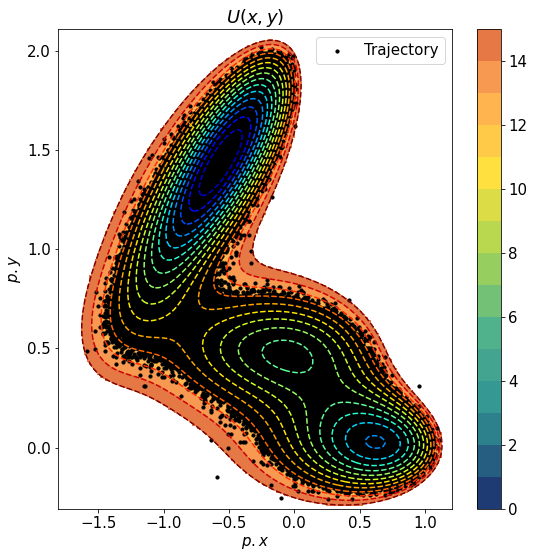

In [7]:
fig, ax = plt.subplots(figsize=(8,8))

x,y = load_dataframe(folder+"COLVAR").filter(regex="^p.x").values,load_dataframe(folder+"COLVAR").filter(regex="^p.y").values
ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

#bounds = np.arange(np.min(Z), np.max(Z), 5.)
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")

c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energy Surface"
)
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
#-- if put label on isolines --#
#c.clabel()

ax.legend()
ax.set_xlabel(r"$p.x$")
ax.set_ylabel(r"$p.y$")
ax.set_title(r'$U(x,y)$')
plt.tight_layout()

In [8]:
x = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()
N = len(x)
x = x.reshape(N)
weight= np.exp(np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"])

In [9]:
average = np.average(x,weights=weight)
variance = np.cov(x,aweights=weight)
print("average: ",average, ", variance: ",variance)

average:  -0.5629119302538494 , variance:  0.007705014114222502


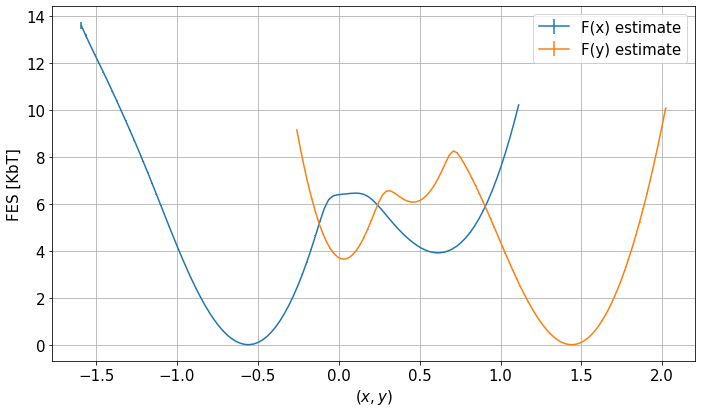

In [10]:
#-- estimation of Free Energy Surface 1D --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(10,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
ax.set_xlabel(r"$(x,y)$")
ax.set_ylabel("FES [KbT]")

plt.tight_layout()
plt.show()

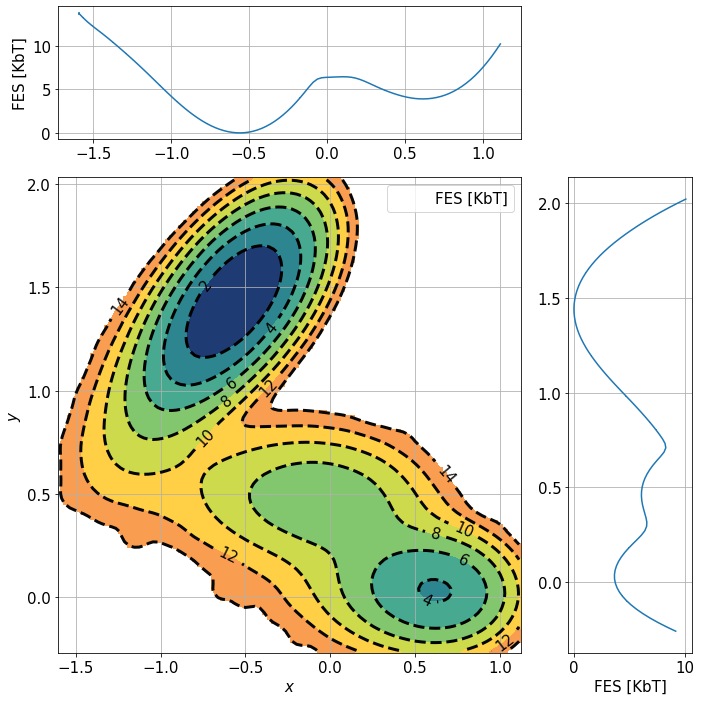

In [11]:
gridspec_fes(s,logweight,sim_parameters)

## Bias simulation TICA Analysis  

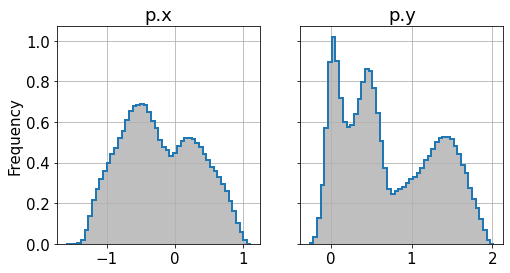

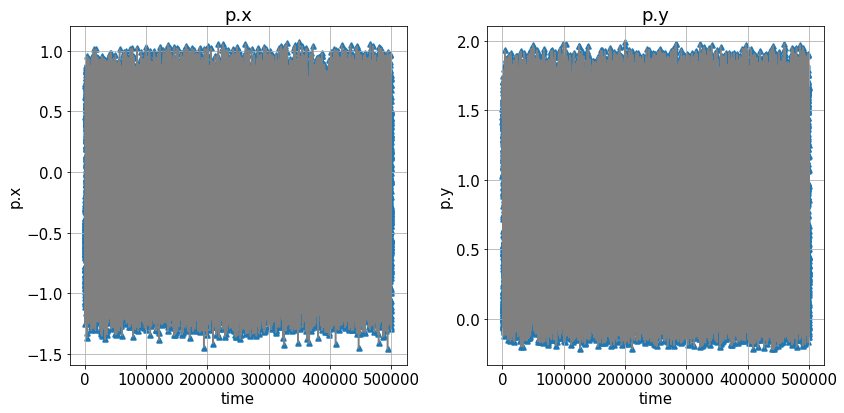

In [12]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

In [13]:
#-- TRAINING PARAMETERS --#
train_parameters = {
              'descriptors': '^p.',
              'lag_time':1,
              'standardize_outputs':True,
              'standardize_inputs': True,
              #if reweight the timescale
              "reweighting": True,
              }
#--------------------------------------#

## DeepTICA Analysis and Export

In [14]:
model,data,logweight,X,names = training(sim_parameters["temp"],folder+"COLVAR",train_parameters,tprime=None)
#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

model.set_params({"feature_names": names})
print( model.plumed_input() )

timescales:  [11.377554   1.3523695]
eigenvalues:  [0.91585946 0.47737983]
tica_cv1: CUSTOM ARG=p.x,p.y VAR=x0,x1 FUNC=+0.451694*(x0+0.307798)-0.892173*(x1-0.933295) PERIODIC=NO
tica_cv2: CUSTOM ARG=p.x,p.y VAR=x0,x1 FUNC=+0.802210*(x0+0.307798)+0.597042*(x1-0.933295) PERIODIC=NO



#### Adding to data the cvs values

In [15]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

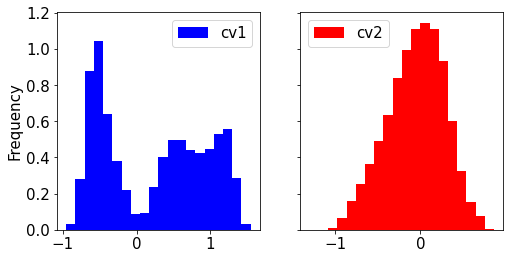

In [16]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

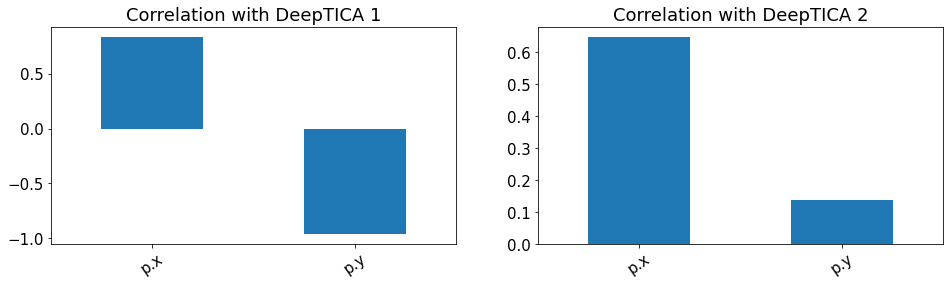

In [17]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35)
    axs[k].set_title('Correlation with TICA '+str(k+1))
plt.show()

### FES estimate from new cvs  

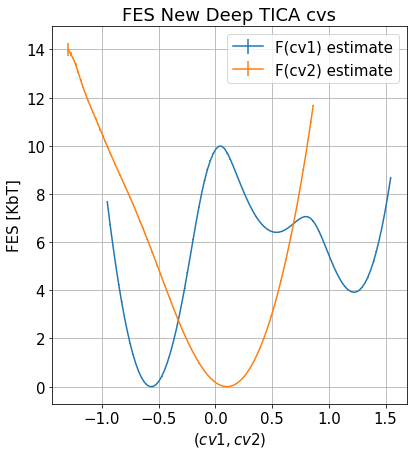

In [18]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES New TICA cvs")

plt.show()

### Free Energy Estimation from sampled TICA Cvs

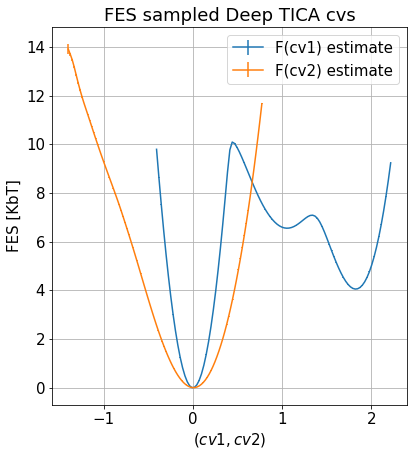

In [19]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^tica").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES sampled TICA cvs")

plt.show()

### Isolines  

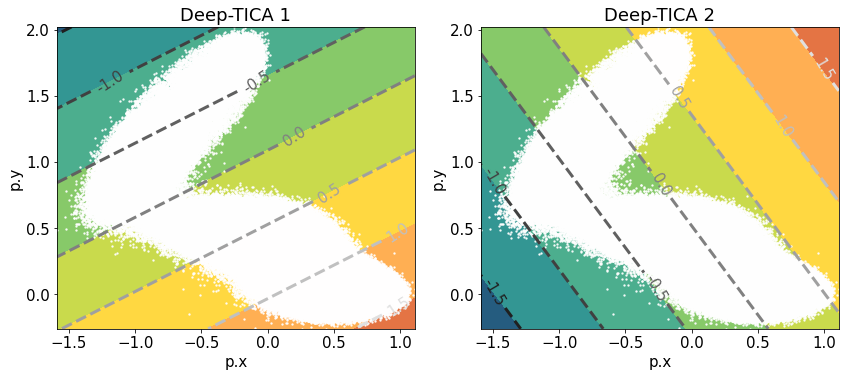

In [20]:
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

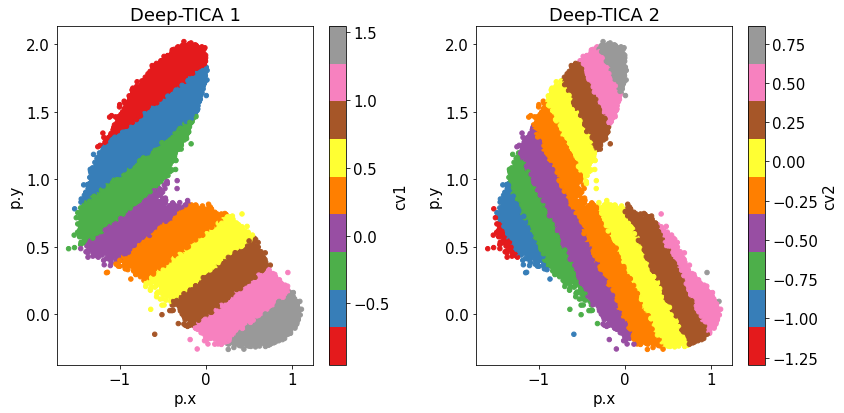

In [21]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
Now we want to estimate the scalar product of the Deep-TICA Cvs. In this case we have to reweight the integrale, because our points are distributed according to $p(\vec x) = \dfrac{e^{-\beta ( U(\vec x) + V (\vec cv(\vec x)))}}{\mathcal{Z}}$. Then finally the scalar product is computed from the following integral $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta ( U(\vec x) + V (\vec cv(\vec x)))} e^{\beta ( V(\vec cv(\vec x))}$.  
  
Even in this case, as already observed their scalar product on the data will lead to a result slightly different from $0$, due to the enforced simmetryzation of $C(\tau)$

In [22]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

-0.003014999162472614

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [23]:
#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X,logweight=logweight)
prod = np.multiply(np.multiply(cv1,np.exp(logweight)),new_cv2).mean()
print(prod)

-3.832874282883062e-11


Text(0.5, 1.0, 'Deep-TICA 2 orthogonal')

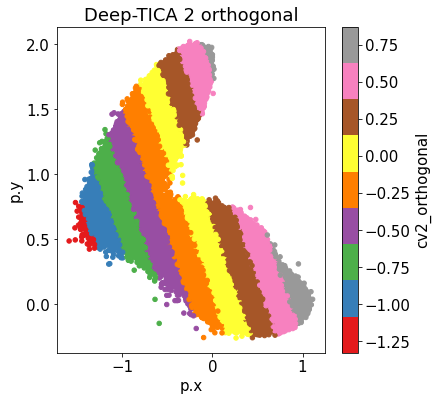

In [24]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="p.y",x="p.x",c="cv2_orthogonal",cmap="Set1",ax=ax)
ax.set_title('Deep-TICA 2 orthogonal')

## $\Delta F$ Estimate

Text(0.5, -0.03, 'shadow error of 0.5KbT')

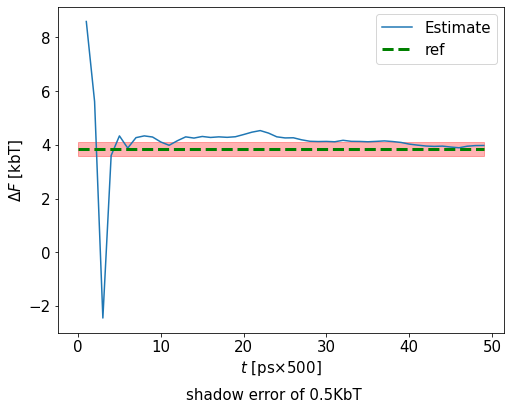

In [25]:
res = 3.841414368598573
#-- each step is 1ps --#
#-- we are interested in the first 50 ns --#
last = 1*1000*25#0 #last ns
data = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()[:last]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]
logweight= (logweight-np.max(logweight))/sim_parameters["temp"]
#-- each step is 1ps --#
#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=500

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data[:el]
    weight = np.exp(logweight[:el])
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        kbt=sim_parameters["temp"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) & (grid>-1.3)
    ind2 = (grid>0) & (grid<1)
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]/sim_parameters["temp"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]/sim_parameters["temp"]), grid2)
    
    deltaf = np.append(deltaf,(sim_parameters["temp"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),0.5*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.grid()
ax.set_xlabel(r"$t$ [ps$\times$"+str(CLEAR)+"]")
ax.set_ylabel(r"$\Delta F$ [kbT]")
txt = "shadow error of 0.5KbT"
# center text
fig.text(.5, -.03, txt, ha='center')